# Nipype Full Framework Demo

## Microservices Model

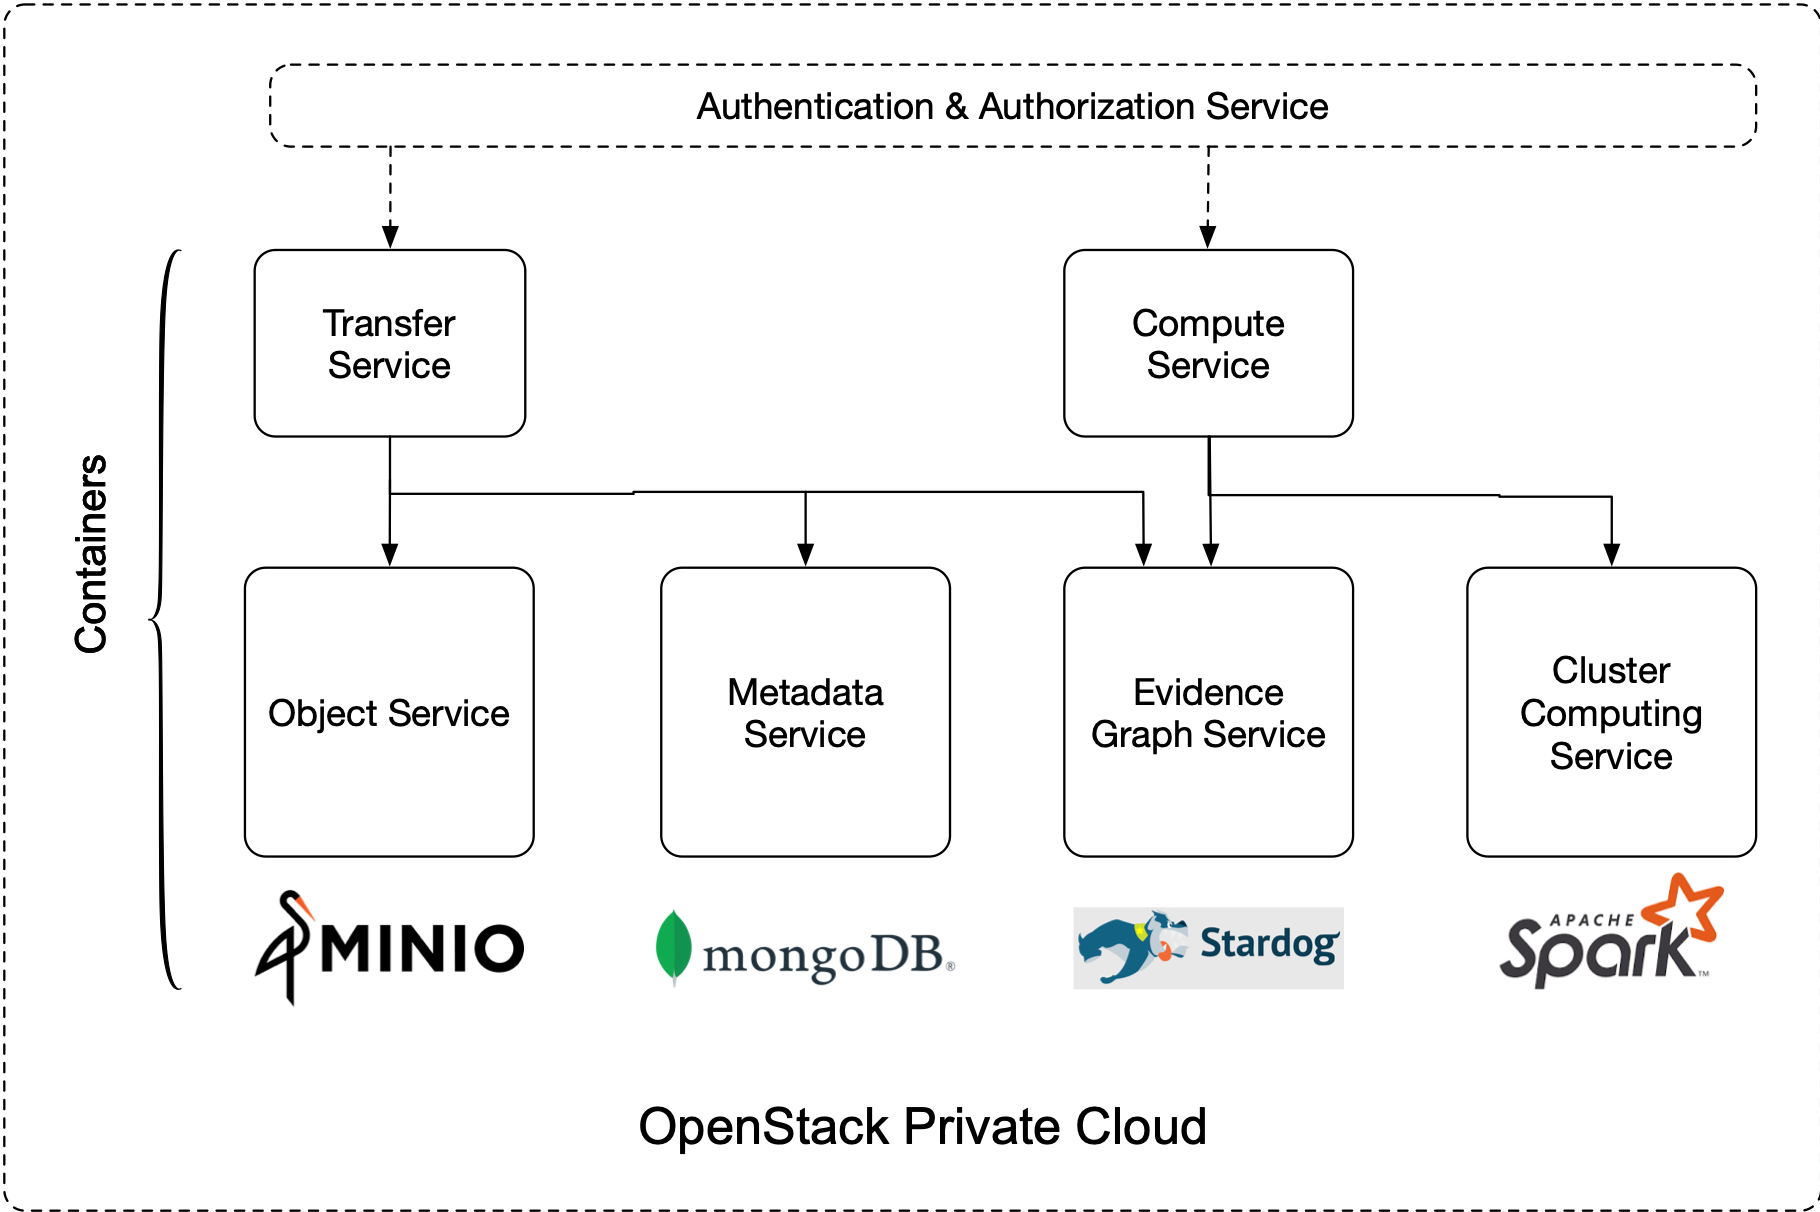

In [1]:
from IPython.display import Image
Image(filename="Architecture Image.png")

## Service Defintions

    Transfer Service: Used to upload data with associated metadata to framework
    Metadata Service (MDS): Handles minting identifiers...
    Compute Service: Runs nipype wf's spark jobs on uploaded data
    Evidence Graph Service: Queries Stardog to build Evidence Graph tracking object proveance

## This Demo demonstrates
    1.) Upload data to the framework
    2.) Retreive metadata of an uploaded object using MDS
    3.) Run a nipype workflow on uploaded data
    4.) View evidence graph of output from the workflow
    5.) Visualize evidence graph of an ouput from a workflow

## Use Transfer Service to Upload Data with Metadata
Transfer Service: Uploads (raw) data into MinIO and the metadata into MondoDB 

#### Metadata:

In [2]:
import requests 
import json

dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"sub-01_t1w_preproc.nii.gz",
    "description":"sub-01 preproccesed",
    "author":'Michael Notter',
    'folder':'inputs'
}

#### Service Call:
Invoking the Transfer Service to upload the data and the corresponding metadata:

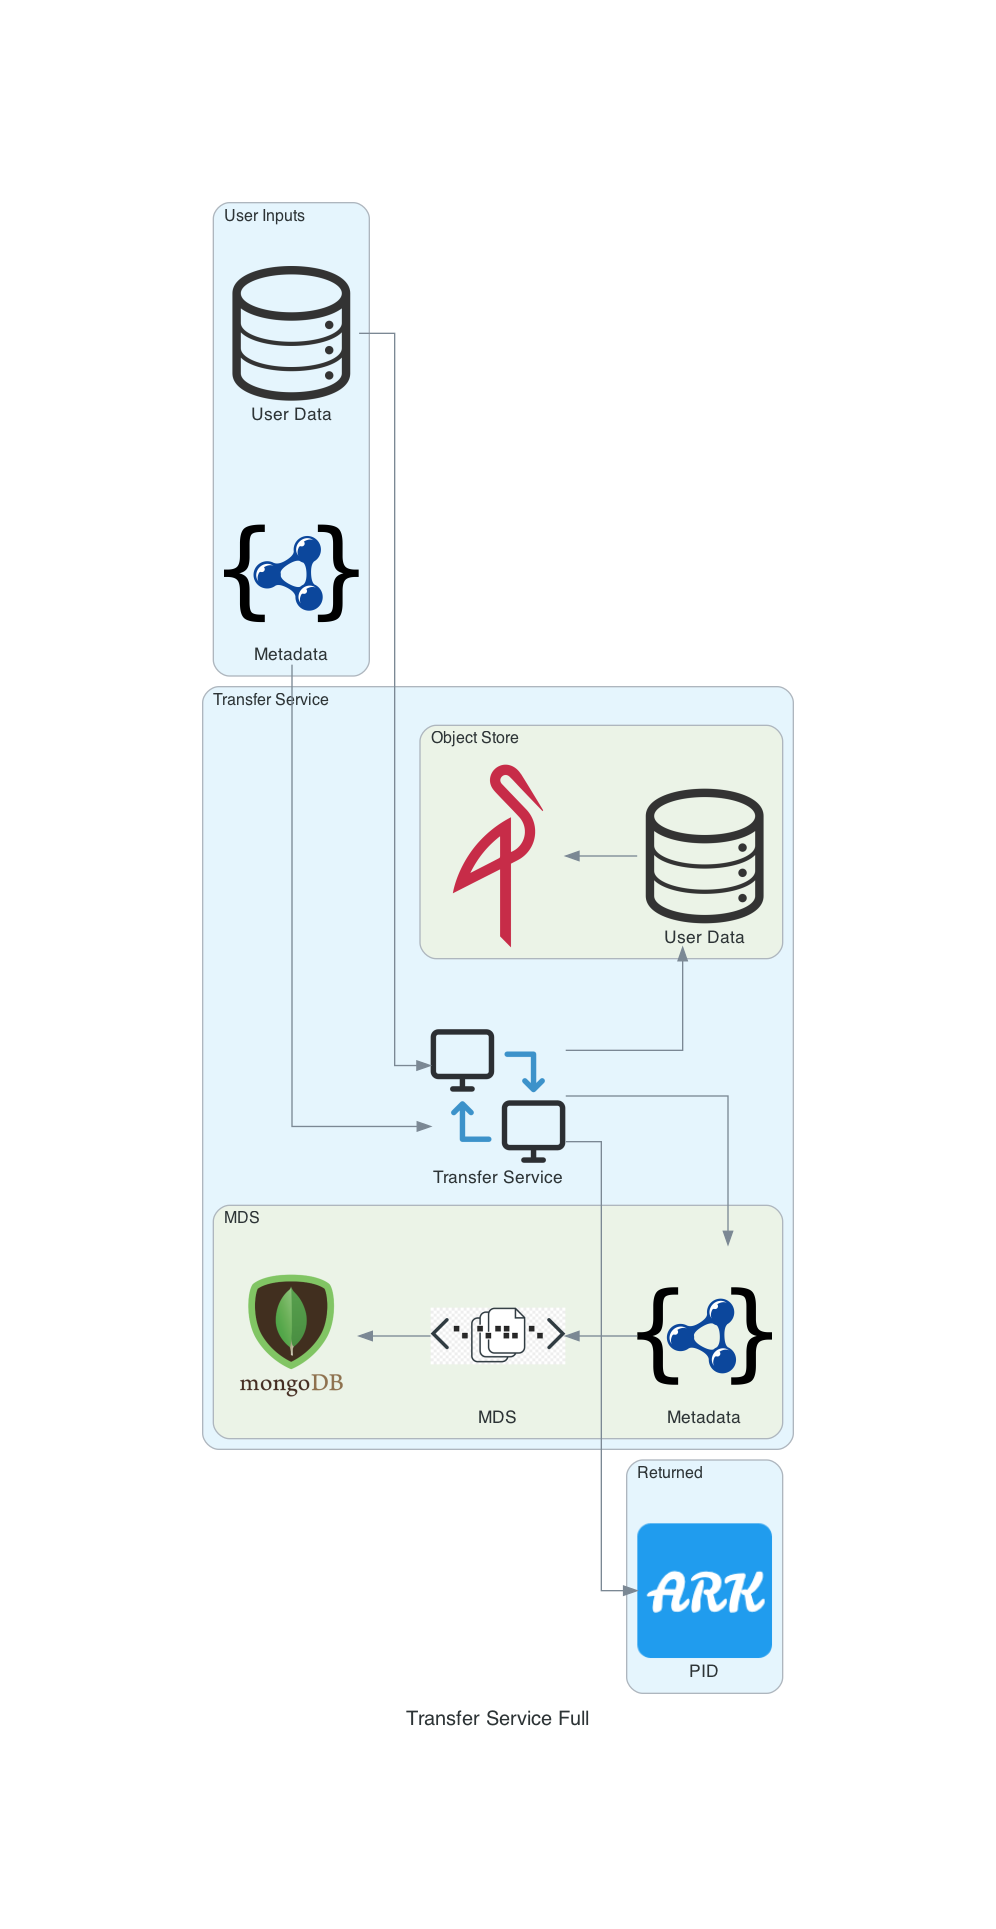

In [9]:
Image('transfer_service_full.png')

In [3]:
files = {
    'files':open('sub-01_t1w_preproc.nii.gz','rb'),
    'metadata':json.dumps(dataset_meta)
}

In [4]:
url = 'https://clarklab.uvarc.io/transfer/data/'
r = requests.post(url,files=files)
data_upload = r.json()
data_id1 = r.json()['Minted Identifiers'][0]

#### Transfer Service Response:
Examine the response to the service execution, includes newly minted PID

In [5]:
data_upload

{'All files uploaded': True,
 'Failed to mint Id for': [],
 'Minted Identifiers': ['ark:99999/e6640f51-4ecc-41ca-a1af-d1d15236d7e7'],
 'failed to upload': []}

## Call MDS to Get Metadata for Minted ID
MDS: Retrieve Metadata for the Minted ID

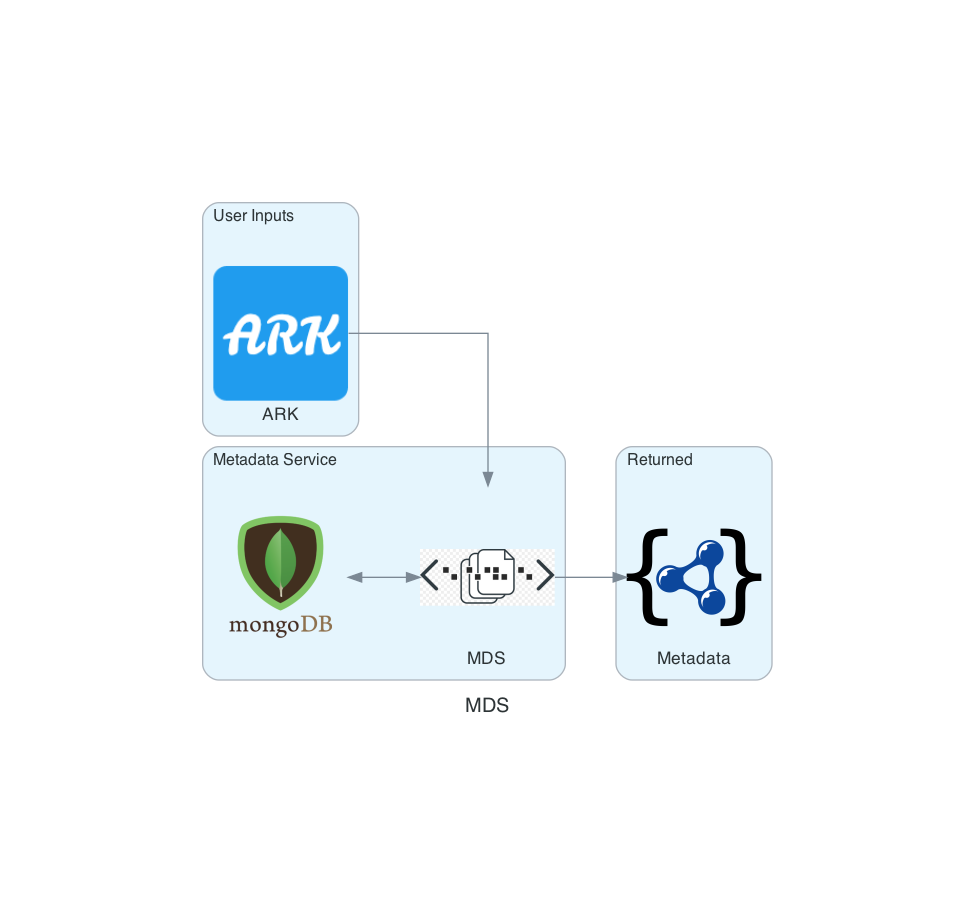

In [8]:
Image('mds.png')

In [6]:
metadata = requests.get('https://clarklab.uvarc.io/mds/' + data_id1).json()
metadata

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/e6640f51-4ecc-41ca-a1af-d1d15236d7e7',
 '@type': 'Dataset',
 'author': 'Michael Notter',
 'description': 'sub-01 preproccesed',
 'distribution': [{'@id': 'ark:99999/173819b4-92a7-42c9-8f36-a69e63b7632e',
   '@type': 'DataDownload',
   'contentSize': 34678574,
   'contentUrl': 'minionas.uvadcos.io/breakfast/inputs/sub-01_t1w_preproc.nii.gz',
   'fileFormat': 'gz',
   'name': 'sub-01_t1w_preproc.nii.gz'}],
 'name': 'sub-01_t1w_preproc.nii.gz',
 'sdPublicationDate': '2020-07-29T00:30:05.925686105Z',
 'url': 'http://ors.uvadcos.io/ark:99999/e6640f51-4ecc-41ca-a1af-d1d15236d7e7'}

## Upload Second Dataset Needed
Follow same steps as above to upload second dataset needed for our example workflow

In [7]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"sub-01_ses-test_task-fingerfootlips_bold.nii.gz",
    "description":"sub-01 task",
    "author":'Michael Notter',
    'folder':'inputs'
}

In [8]:
files = {
    'files':open('sub-01_ses-test_task-fingerfootlips_bold.nii.gz','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'https://clarklab.uvarc.io/transfer/data/'
r = requests.post(url,files=files)
data_id2 = r.json()['Minted Identifiers'][0]


## Upload Nipype WF via Transfer Service
Transfer Service can also be used to upload software

Software uploads also require associated metadata to be uploaded with the data

In [9]:
software_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"Sample Neuro Workflow",
    "description":"sub-01 task",
    "author":'Michael Notter',
    "folder":"inputs"
}

### Workflow pulled from

https://miykael.github.io/nipype_tutorial/notebooks/example_preprocessing.html

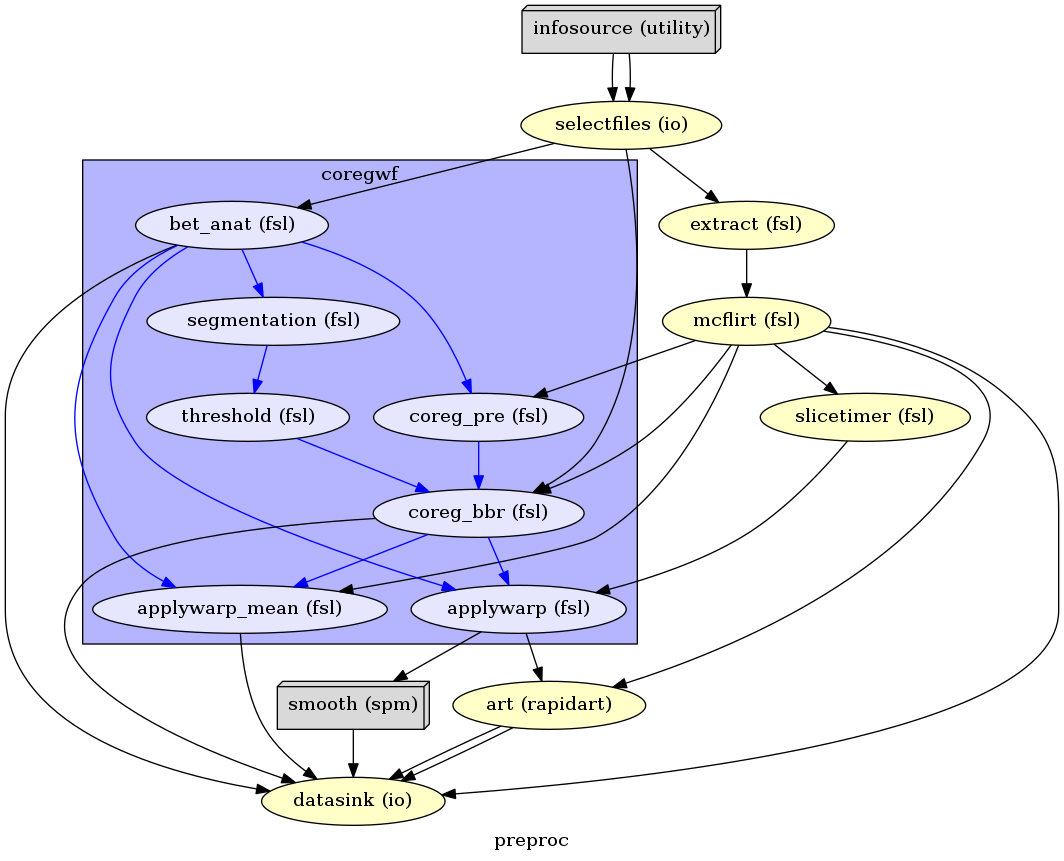

In [3]:
Image(filename="nipype_wf.png")

In [10]:
files = {
    'files':open('new_script.py','rb'),
    'metadata':json.dumps(software_meta)
}

url = 'https://clarklab.uvarc.io/transfer/data/'
r = requests.post(url,files=files)
software_id = r.json()['Minted Identifiers'][0]


## Call Compute Service to Run WF on Posted Data

#### Compute Service Call 
Must pass compute service data ids of interest and which workflow to run

In [11]:
job = {"datasetID":[data_id1,data_id2],"scriptID":software_id,'node':'worker-node2'}

R = requests.post("https://clarklab.uvarc.io/compute/nipype",json = job)
job_id = R.content.decode()
job_id

'ark:99999/2ee431b3-5fea-4005-bf6d-dc12609ff059'

In [33]:
requests.get('https://clarklab.uvarc.io/mds/' + job_id).json()

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/1dd9b10f-aa59-4e02-a5a6-01e1361955d8',
 '@type': 'evi:Computation',
 'began': 'Tuesday, July 28, 2020 11:27:06',
 'ended': 1595979217.330763,
 'evi:supports': ['ark:99999/95d4e135-5cdb-4bce-a01b-99058682aabc',
  'ark:99999/43078787-047f-42dc-b059-85db11e96465',
  'ark:99999/106fd61b-330f-4fd3-8fa3-46f445d594f4',
  'ark:99999/68f2c981-a82f-4357-a967-d2b91e94fadc',
  'ark:99999/50c542f4-770d-490a-8ddf-c98390e5163d',
  'ark:99999/36485a7f-4934-4b8a-bcb9-0474d1758d29',
  'ark:99999/43d508ca-621b-4b13-9f0d-d84a3174991d',
  'ark:99999/62990475-9aa8-435f-8816-09bb3e8fe35a',
  'ark:99999/04d6465e-99f4-460f-a6fb-8a1a9c89bd9d',
  'ark:99999/77e2edea-a49a-4026-add7-2845c796117e',
  'ark:99999/4e4f7cc8-4296-4c14-a76f-b319864171ce',
  'ark:99999/9f6bdc6a-d434-4b60-a8a4-737b3c62db3e',
  'ark:99999/0be2dd17-091a-4e8d-b2e5-2a71784379c6',
  'ark:99999/d331ec6e-b1ae-4f66-b812-2e5aa36ece06',
  'ark:99999/6988fad7-4605-49f6-ba30-eeb8c84c49e

job_id is an identifier representing the compuation being performed 

#### Using Minted Job ID Check Status of the Job with Second Call to Compute Service

In [18]:
requests.get("http://clarklab.uvarc.io/compute/job/" + job_id).json()

{'Status': 'Succeeded'}

## Review Job Outputs

#### Get all Minted Output IDs

In [19]:
all_outputs = requests.get('https://clarklab.uvarc.io/mds/' + job_id).json()['evi:supports']

In [20]:
requests.get('https://clarklab.uvarc.io/mds/' + job_id).json()

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/2ee431b3-5fea-4005-bf6d-dc12609ff059',
 '@type': 'evi:Computation',
 'began': 'Wednesday, July 29, 2020 12:31:16',
 'ended': 1595983067.0195007,
 'evi:supports': ['ark:99999/2edb1570-7958-4f2f-afce-541e7b0818b9',
  'ark:99999/e5703de8-d061-4b18-8a80-aa4ae49f2b27',
  'ark:99999/a48429ec-6adf-4c7a-80cf-c649f61d4988',
  'ark:99999/7355d172-fb99-4084-9f3c-38c2806e6485',
  'ark:99999/daedd490-b3fb-4a73-8f09-da5f6a7070f1',
  'ark:99999/6a740c8b-44d8-456b-ae87-9918df4548ad',
  'ark:99999/24702f99-15da-4cf5-afdf-e50b25b56116',
  'ark:99999/04f2b77d-93cd-4a4a-87ba-85c7c23eb30f',
  'ark:99999/72336be2-8ac3-49cf-81b6-b74f600fa4a5',
  'ark:99999/b7f72241-195b-4ef8-bce1-05b96e42964a',
  'ark:99999/125359c8-12ca-439d-be08-30427fcd6467',
  'ark:99999/1db299a4-8db4-475b-95cf-316212a0cca0',
  'ark:99999/b0134056-a0e3-493c-8cd6-83228263b50b',
  'ark:99999/5455d5d1-150c-4584-b53c-e1a4d579ad4f',
  'ark:99999/2b9d006a-e75a-4d05-8307-759ff0e5

#### Check Individual Output Metadata with Call to MDS

Long Evidence Graph

In [21]:
output_of_interest = all_outputs[-3]
requests.get('https://clarklab.uvarc.io/mds/' + output_of_interest).json()

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/5f284456-02d0-4682-a367-3d3354180ff2',
 '@type': 'Dataset',
 'distribution': [{'@id': 'ark:99999/0706a26a-a30c-4355-a07e-9e754f7c7e40',
   '@type': 'DataDownload',
   'contentSize': 332460,
   'contentUrl': 'minionas.uvadcos.io/breakfast/2ee431b3-5fea-4005-bf6d-dc12609ff059/sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz',
   'fileFormat': 'gz',
   'name': 'sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz'}],
 'evi:generatedBy': {'@id': 'ark:99999/23a3a4c5-d15c-44b3-8d99-23fae20b4be5'},
 'name': 'preproc.datasink.a1.b0.out_file',
 'sdPublicationDate': '2020-07-29T00:37:11.319981791Z',
 'url': 'http://ors.uvadcos.io/ark:99999/5f284456-02d0-4682-a367-3d3354180ff2'}

Short Evidence Graph

In [23]:
output_of_interest = all_outputs[3]
requests.get('https://clarklab.uvarc.io/mds/' + output_of_interest).json()

{'@context': {'@vocab': 'http://schema.org/'},
 '@id': 'ark:99999/7355d172-fb99-4084-9f3c-38c2806e6485',
 '@type': 'Dataset',
 'distribution': [{'@id': 'ark:99999/e10b7f2f-44f1-4945-95b4-4786e0c98eb1',
   '@type': 'DataDownload',
   'contentSize': 437786,
   'contentUrl': 'minionas.uvadcos.io/breakfast/2ee431b3-5fea-4005-bf6d-dc12609ff059/sub-01_t1w_preproc_brain_pve_2.nii.gz',
   'fileFormat': 'gz',
   'name': 'sub-01_t1w_preproc_brain_pve_2.nii.gz'}],
 'evi:generatedBy': {'@id': 'ark:99999/0a05a057-9037-4746-b9ee-d31a200b14cd'},
 'name': 'preproc.coregwf.segmentation.b0.partial_volume_files',
 'sdPublicationDate': '2020-07-29T00:36:35.015625046Z',
 'url': 'http://ors.uvadcos.io/ark:99999/7355d172-fb99-4084-9f3c-38c2806e6485'}

## Call Evidence Graph Service to See Evidence Graph of Output

In [24]:
eg = requests.get('https://clarklab.uvarc.io/evidencegraph/eg/' + output_of_interest).json()
eg

{'@context': {'@vocab': 'http://schema.org/', 'evi': 'http://purl.org/evi/'},
 '@id': 'ark:99999/7355d172-fb99-4084-9f3c-38c2806e6485',
 '@type': 'Dataset',
 'evi:generatedBy': {'@id': 'ark:99999/0a05a057-9037-4746-b9ee-d31a200b14cd',
  '@type': 'evi:Computation',
  'evi:usedDataset': {'@id': 'ark:99999/2edb1570-7958-4f2f-afce-541e7b0818b9',
   '@type': 'Dataset',
   'evi:generatedBy': {'@id': 'ark:99999/48d15b1d-facc-4667-bbf3-b11040903a27',
    '@type': 'evi:Computation',
    'evi:usedDataset': {'@id': 'ark:99999/e6640f51-4ecc-41ca-a1af-d1d15236d7e7',
     '@type': 'Dataset',
     'author': 'Michael Notter',
     'name': 'sub-01_t1w_preproc.nii.gz'},
    'evi:usedSoftware': {'@id': 'ark:99999/9535ecaa-2f68-4e4c-9452-c3b293aedb3a',
     '@type': 'SoftwareSourceCode',
     'name': 'FSL BET'},
    'name': 'Computation preproc.coregwf.bet_anat.b0'},
   'name': 'preproc.coregwf.bet_anat.b0.out_file'},
  'evi:usedSoftware': {'@id': 'ark:99999/845f7f3a-12db-4dba-b705-a7f4e92e4d22',
   '@typ

## Visualization of Evidence Graph

In [25]:
'https://clarklab.uvarc.io/viz/' + output_of_interest

'https://clarklab.uvarc.io/viz/ark:99999/7355d172-fb99-4084-9f3c-38c2806e6485'

In [ ]:
visual = requests.get('http://visualize.default/' + output_of_interest).json()
#Will need to add things here to show html clearly
visual

### If of interest there's a second workflow that uses outputs of first

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"task-fingerfootlips_events.tsv",
    "description":"Events tsv for all subjects"
}

In [ ]:
files = {
    'files':open('task-fingerfootlips_events.tsv','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
r.content.decode()
"ark:99999/88f69ce2-8725-4d5c-abd1-e418d32c55a2"

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"First Analysis Step",
    "description":"Follow-up script after preproccsing",
    "author":'Michael Notter'
}

In [1]:
{'@id': 'ark:99999/e98abd34-7745-4d82-8bed-81bf863734ce', 'eg:generatedBy': {'@id': 'ark:99999/3f81d2bd-82a3-490f-91ea-5203f3e5b525', 'eg:usedDataset': {'@id': 'ark:99999/4c334a12-1ae6-4ae9-b3e6-99398d16a44b', 'eg:generatedBy': {'@id': 'ark:99999/ef2a6cad-d531-4739-93cf-c616e512250d', 'eg:usedDataset': {'@id': 'ark:99999/c93b8e12-c10f-4f87-8a16-0bb775c88005', '@type': 'Dataset', 'author': 'Michael Notter', 'eg:generatedBy': {'@id': 'ark:99999/00b1935a-a3f9-47c3-bad0-410f9c9b9e4c', 'eg:usedDataset': {'@id': 'ark:99999/eff9c6a5-742a-4f68-af10-33860ed86f99', 'eg:generatedBy': {'@id': 'ark:99999/756364ca-e733-498b-bf02-5211c49f6d90', 'eg:usedDataset': {'@id': 'ark:99999/d0caff28-c328-46b6-a68a-dbb18565d3b8', 'eg:generatedBy': {'@id': 'ark:99999/d4a8cfe5-6270-4fe6-850a-1e0d4fb1b845'}, 'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii'}, 'eg:usedSoftware': 'ark:99999/c2b8b21a-cc5b-49f0-970b-424726cb2ad7'}, 'name': 'sub-01_t1w_preproc_brain_pve_2.nii.gz'}, 'eg:usedSoftware': 'ark:99999/e54e4ffa-3b52-4338-9b25-a5e6cfed8106'}, 'name': 'sub-01_t1w_preproc.nii.gz'}, 'eg:usedSoftware': 'ark:99999/347b9a85-fe84-4067-9916-19d4966a8ecd'}, 'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par'}, 'eg:usedSoftware': 'ark:99999/e88af7ba-b10a-4561-b99f-02e7ad991e7b'}, 'name': 'fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii'}

{'@id': 'ark:99999/e98abd34-7745-4d82-8bed-81bf863734ce',
 'eg:generatedBy': {'@id': 'ark:99999/3f81d2bd-82a3-490f-91ea-5203f3e5b525',
  'eg:usedDataset': {'@id': 'ark:99999/4c334a12-1ae6-4ae9-b3e6-99398d16a44b',
   'eg:generatedBy': {'@id': 'ark:99999/ef2a6cad-d531-4739-93cf-c616e512250d',
    'eg:usedDataset': {'@id': 'ark:99999/c93b8e12-c10f-4f87-8a16-0bb775c88005',
     '@type': 'Dataset',
     'author': 'Michael Notter',
     'eg:generatedBy': {'@id': 'ark:99999/00b1935a-a3f9-47c3-bad0-410f9c9b9e4c',
      'eg:usedDataset': {'@id': 'ark:99999/eff9c6a5-742a-4f68-af10-33860ed86f99',
       'eg:generatedBy': {'@id': 'ark:99999/756364ca-e733-498b-bf02-5211c49f6d90',
        'eg:usedDataset': {'@id': 'ark:99999/d0caff28-c328-46b6-a68a-dbb18565d3b8',
         'eg:generatedBy': {'@id': 'ark:99999/d4a8cfe5-6270-4fe6-850a-1e0d4fb1b845'},
         'name': 'sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii'},
        'eg:usedSoftware': 'ark:99999/c2b8b21a-cc5b-49f0-970b-424726cb2ad7'},
  

In [ ]:
files = {
    'files':open('2nd Step.py','rb'),
    'metadata':json.dumps(dataset_meta)
}

url = 'http://transfer-service/data/'
r = requests.post(url,files=files)
r.content.decode()
ark:99999/251fb7cf-1711-472e-a54d-3834efba92ef

In [ ]:
data_ids = requests.get('http://mds.ors/ark:99999/fc813955-d8ba-4a88-800a-e5fc21a1119e').json()['eg:supports']
data_ids.append("ark:99999/88f69ce2-8725-4d5c-abd1-e418d32c55a2")
script_id = 'ark:99999/251fb7cf-1711-472e-a54d-3834efba92ef'
job = {"datasetID":data_ids,"scriptID":script_id}

R = requests.post("http://sparksubmit/nipype",json = job)
R.content.decode()